In [2]:
from DataReader import DataReader
dataReader = DataReader(datasetDirectory="data/pipes/")

Found 14 images in data/pipes/images\dslr_images_undistorted dataset.


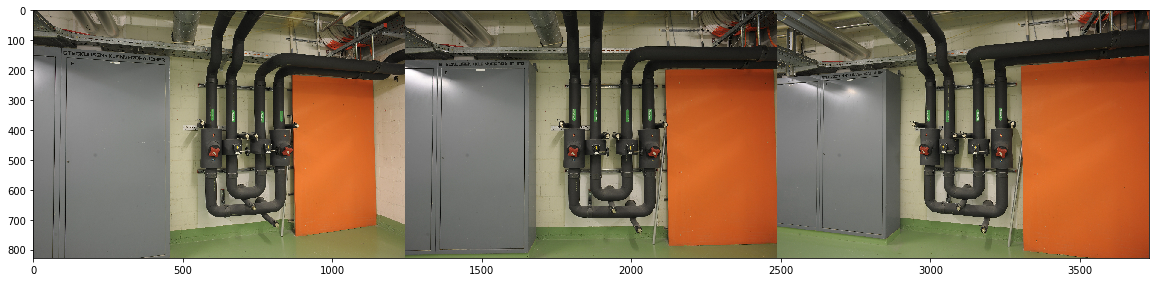

In [7]:
import numpy as np
import matplotlib.pyplot as plt

frames = [dataReader.readFrame("{:04d}".format(i), convertToRGB=True, scale=0.2) for i in range(1, 4)]

plt.figure(figsize=(20, 15))
plt.imshow(np.hstack((frames[0], frames[1], frames[2])))

## Feature extraction

In [8]:
import cv2

sift = cv2.xfeatures2d.SIFT_create(nfeatures=300)

keyptDescr = np.array([sift.detectAndCompute(f, mask=None) for f in frames])

keypoints = keyptDescr[:,0]
descriptors = keyptDescr[:,1]

In [12]:
print(f"Number of keypoints detected in each image: {[len(k) for k in keypoints]}")
# keypointsImage = cv2.drawKeypoints(frames[0], keypoints[0], None)
# plt.figure(figsize=(15, 15))
# plt.imshow(keypointsImage)
# plt.show()

Number of keypoints detected in each image: [301, 300, 301]


## Feature matching


In [13]:
matcher = cv2.BFMatcher(crossCheck=True)
matches = matcher.match(queryDescriptors=descriptors[0], trainDescriptors=descriptors[1])
print(f"Found total {len(matches)} matches between images (0, 1) (unfiltered).")

# matchesImage = cv2.drawMatches(frames[0], keypoints[0], frames[1], keypoints[1], matches, None, flags=2)
# plt.figure(figsize=(20, 20))
# plt.imshow(matchesImage)

Found total 176 matches between images (0, 1) (unfiltered).
